In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Lab 4: Fire and Tree Mortality
Author: Zoe Zhou
# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | Tree status 1 year after fire
| YrFireName                  | Year and name of fire                                    
| Times_burned                | Numbers of time this tree was burned                                             
| Species                     | Tree species abbreviation                                                    
| Genus_species               | Genus and species of tree                                      
| DBH_cm                      | Diameter at breast height
| HT_m                        | Pre-fire tree height 
| CR_pre                      | Pre-fire crown ratio
| CR_post                     | Post-fire crown ratio

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')
# Select columns
trees_dat = trees_dat[['yr1status', 'YrFireName', 'Times_burned', 'Species', 'Genus_species','DBH_cm', 'HT_m', 'CR_pre', 'CR_post']]
# Check and remove na
trees_dat = trees_dat.dropna()
print(trees_dat.isna().sum())
# Print number of observations
print(f"\nNumber of Observations: {trees_dat.shape[0]}")

yr1status        0
YrFireName       0
Times_burned     0
Species          0
Genus_species    0
DBH_cm           0
HT_m             0
CR_pre           0
CR_post          0
dtype: int64

Number of Observations: 36509


/tmp/ipykernel_1469578/193754660.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [3]:
# check data types
trees_dat.dtypes

# Convert categorical columns to integer codes using pd.factorize
categorical_columns = ['YrFireName', 'Species', 'Genus_species']

for col in categorical_columns:
    trees_dat[col], _ = pd.factorize(trees_dat[col])

# Check date types
trees_dat.dtypes

yr1status        float64
YrFireName         int64
Times_burned       int64
Species            int64
Genus_species      int64
DBH_cm           float64
HT_m             float64
CR_pre           float64
CR_post          float64
dtype: object

2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [4]:
trees_dat.head()

,yr1status,YrFireName,Times_burned,Species,Genus_species,DBH_cm,HT_m,CR_pre,CR_post
500,0.0,0,1,0,0,71.374,41.76,0.84,0.74
501,0.0,0,1,0,0,23.622,12.80,0.60,0.57
502,0.0,0,1,0,0,46.228,34.75,0.75,0.59
503,0.0,0,1,0,0,21.082,23.16,0.38,0.38
504,0.0,0,1,0,0,24.384,26.21,0.42,0.42


In [5]:
# Assign predictor and outcome variables 
X = trees_dat[[ 'YrFireName', 'Times_burned', 'Species', 'Genus_species','DBH_cm', 'HT_m', 'CR_pre', 'CR_post']]
y = trees_dat.yr1status

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# Standardize the predictors
scaler = StandardScaler() # Calculate mean 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # scale X_test with what mean and variance calculated in X_train

3. How many training/test observations do we have? Print your answer in the cell below. 

In [6]:
# Verify the training and testing set size
print("Training set observations:", len(X_train_scaled))
print("Testing set observations:", len(X_test_scaled))

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [7]:
# Initialize model
classifier = LogisticRegression()
# Fit model with training set 
classifier.fit(X_train_scaled, y_train)
# Use model for prediction 
y_train_pred = classifier.predict(X_train_scaled)
# Access model accuracy on training set
mse_train = mean_squared_error(y_train, y_train_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {accuracy_train: .4f}")
print(f"mse: {mse_train: .4f}")


Training Accuracy:  0.9436
mse:  0.0564


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

In [8]:
# Prediction with test data
y_test_pred = classifier.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
# Print evaluation metrics
print(f"Accuracy: {test_accuracy: .4f}")

# Calculate confusion matrix
matrix = confusion_matrix(y_test, y_test_pred)

# Calculate metrics
TN = matrix[1,1]
TP = matrix[0,0]
FP = matrix[0,1]
FN = matrix[1,0]
sensitivity = TP / (TP + FN) 
specificity = TN / (TN + FP)

print("\nMetrics from Confusion Matrix:")
print(f"Sensitivity (true positive rate): {sensitivity:.4f}")
print(f"Specificity (true negative rate): {specificity:.4f}")
# visualization
#ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Class 0", "Class 1"]).plot(cmap="Blues", ax=plt.gca())

Accuracy:  0.9393

Metrics from Confusion Matrix:
Sensitivity (true positive rate): 0.9519
Specificity (true negative rate): 0.7165


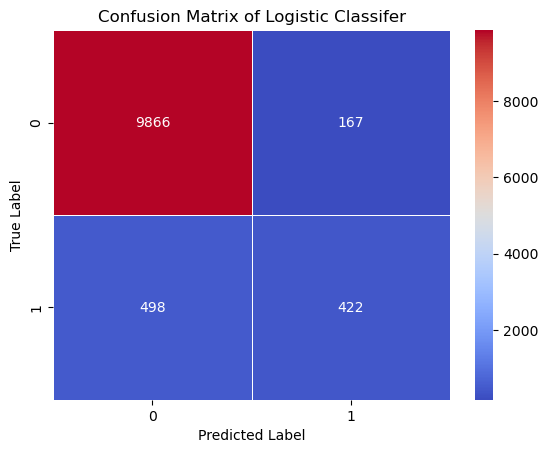


True Positives (correctly predicted alive): 9866
False Positives (Incorrectly predicted alive): 167
True Negatives (correctly predicted dead): 422
False Negatives (incorrectly predicted dead): 498


In [9]:
#Plot confusion matrix
sns.heatmap(matrix,annot=True, cmap='coolwarm', fmt=".0f", linewidths=0.5)
plt.title("Confusion Matrix of Logistic Classifer")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(f"\nTrue Positives (correctly predicted alive): {TP}")
print(f"False Positives (Incorrectly predicted alive): {FP}")
print(f"True Negatives (correctly predicted dead): {TN}")
print(f"False Negatives (incorrectly predicted dead): {FN}")

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

The model reached 94% accuracy on the unseen data. But the model performs better on observation of trees that survived than trees that died: the model correctly predicted 9,866 instances of the "alive" class (True Positives) but only 422 instances of the "dead" class (True Negatives). The number of False Negatives (498) is also higher than False Positives (167). Additionally, there is a class imbalance in the dataset because there are more alive trees observations than dead trees in the dataset as a whole.

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (alive trees)? How would its accuracy compare to your logistic regression model?

A dummy classifier might also predict well because of the class imbalance. In terms of accuracy, I think logistic regression might still do better. 

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

Dummy Accuracy: 0.9172

Dummy Confusion Matrix:


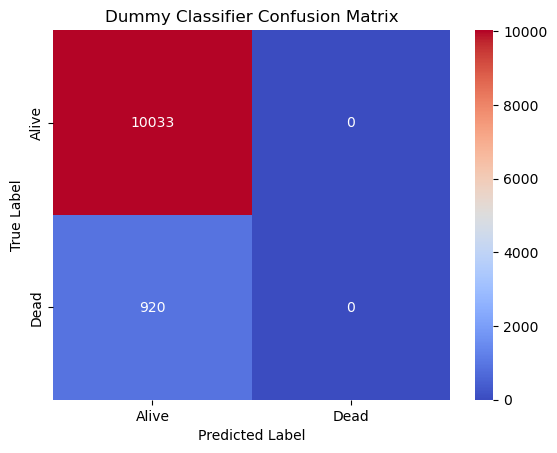


True Positives (correctly predicted alive): 10033
False Positives (Incorrectly predicted alive): 0
True Negatives (correctly predicted dead): 0
False Negatives (incorrectly predicted dead): 920


In [10]:
# create dummy classifier and fit
dummy_classifier = DummyClassifier(strategy="most_frequent").fit(X_train_scaled, y_train)

# Predict within training data
dummy_train_pred = dummy_classifier.predict(X_train_scaled)
# Calculate model's accuracy on training 
dummy_acc_train = accuracy_score(y_train, dummy_train_pred)
# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {dummy_acc_train:.4f}")

# predict on test data
dummy_test_pred = dummy_classifier.predict(X_test_scaled)
# Create confusion matrix
cm = confusion_matrix(y_test, dummy_test_pred)
# Calculate metrics
TN = cm[1,1]
TP = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

print("\nDummy Confusion Matrix:")
sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Alive', 'Dead'], yticklabels=['Alive', 'Dead'])
plt.title("Dummy Classifier Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print(f"\nTrue Positives (correctly predicted alive): {TP}")
print(f"False Positives (Incorrectly predicted alive): {FP}")
print(f"True Negatives (correctly predicted dead): {TN}")
print(f"False Negatives (incorrectly predicted dead): {FN}")

# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [11]:
# Logistic classifier AUC
y_pred_proba = classifier.predict_proba(X_test_scaled)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Logistic AUC: {roc_auc: .4f}")

Logistic AUC:  0.9021


In [12]:
# Dummy classifier AUC
dummy_pred_proba = dummy_classifier.predict_proba(X_test_scaled)[:,1]
dummy_roc_auc = roc_auc_score(y_test, dummy_pred_proba)
print(f"Dummy AUC: {dummy_roc_auc:.4f}")

Dummy AUC: 0.5000


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

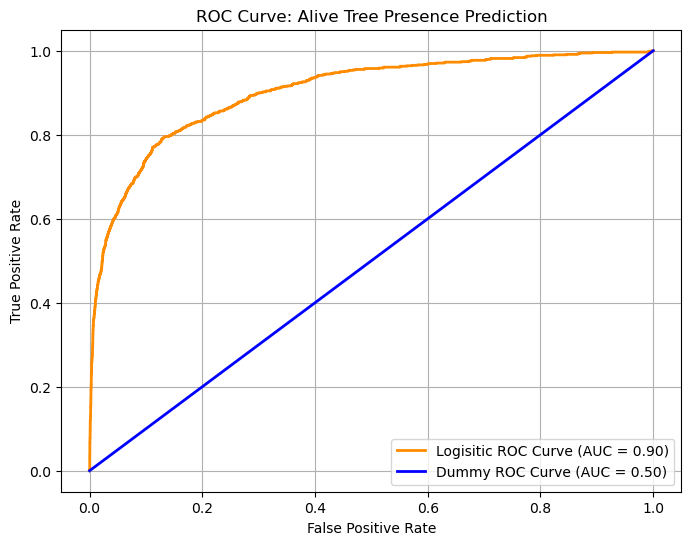

In [13]:
# Get ROC data for both model
fpr, tpr, _= roc_curve(y_test, y_pred_proba)
fpr_dummy, tpr_dummy, _=roc_curve(y_test, dummy_pred_proba)

# Plot curves together
plt.figure(figsize=(8,6))

# Logistic curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Logisitic ROC Curve (AUC = {roc_auc:.2f})')
# Dummy curve
plt.plot(fpr_dummy, tpr_dummy, color='blue', lw=2, label=f'Dummy ROC Curve (AUC = {dummy_roc_auc:.2f})')

plt.title('ROC Curve: Alive Tree Presence Prediction')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

The Area Under the Curve (AUC) for logistic classifier is 0.90, much higher than dummy classifier's AUC (0.5). The illustrates the limitation of using only accuracy to evaluate a model. 

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [14]:
# Create a data frame for feature anmes and importance
importance_df = pd.DataFrame({'Coefficients': classifier.coef_[0]}, index=X.columns).sort_values(by='Coefficients')

# Print the sorted feature importance
print(importance_df)

               Coefficients
CR_post           -2.268484
HT_m              -0.996278
YrFireName        -0.133544
Times_burned       0.000000
CR_pre             0.026231
Species            0.180301
Genus_species      0.180301
DBH_cm             0.413430


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

The most important features influencing tree survival after fire are post-fire crown ratio (CR_post, -2.27) and tree height (HT_m, -0.99), indicating that trees with more remaining crown and greater height are more likely to survive. This suggests that forest management should prioritize maintaining fire-resilient trees by focusing on those with high crown retention and favoring taller individuals during thinning.